## Experiment-0:  COCO

Training params: 
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: True
    - Background subtraction value: 0.1
    - Image-size: 32 x 32
    - Optimizer: Adam
    - Initial LR: 0.001

In [1]:
import os
os.chdir("/nfs/students/winter-term-2020/project-4/yurtkulus/project-4")

%load_ext autoreload
%autoreload 2

In [2]:
from src.data.coco import COCODataModule
import torch
from src.models.pixelcnn import PixelCNN
from src.models.coco_pixelcnn import COCOPixelCNN
from src.experiments.experiment import Experiment
from src.utils.pixelcnn import generate_images
from src.utils.ood_test import plot_roc_auc, test_ood

import torch.nn.functional as F
import matplotlib.pyplot as plt
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
import numpy as np

"""
    In order to obtain foreground and background images from COCO dataset, 
    uncomment the lines below.
"""
# from src.data.oodcoco.oodcoco.oodcoco import run
# run()

'\n    In order to obtain foreground and background images from COCO dataset, \n    uncomment the lines below.\n'

In [3]:
print(os.cpu_count())
torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
seed_everything(42)

20
cuda:0


42

In [4]:
cocodata_person = COCODataModule(foreground_data_dir='./data/COCO/foreground_images/person', 
                                 background_data_dir='./data/COCO/background_images/person', 
                                 convert_grayscale=True,
                                 normalize=True)
# cocodata_person.prepare_data()
# cocodata_person.setup()

cocodata_car = COCODataModule(foreground_data_dir='./data/COCO/foreground_images/car', 
                              background_data_dir='./data/COCO/background_images/car', 
                              convert_grayscale=True, 
                              normalize=True)

# cocodata_dog = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/dog', 
#                               background_data_dir='./data/COCO/background_images/dog', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_teddy_bear = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/teddy bear', 
#                               background_data_dir='./data/COCO/background_images/teddy bear/', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_umbrella = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/umbrella', 
#                               background_data_dir='./data/COCO/background_images/umbrella', 
#                               convert_grayscale=True, 
#                               normalize=True)

# cocodata_clock = COCODataModule(batch_size=8,
#                               foreground_data_dir='./data/COCO/foreground_images/clock', 
#                               background_data_dir='./data/COCO/background_images/clock', 
#                               convert_grayscale=True, 
#                               normalize=True)


# experiment_name = 'PixelCNNBgSub_01_COCO_1'



In [ ]:
experiment_name = 'PixelCNN_COCO_3_Full_Image_bs64_ks7_bgSub'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=50,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=200, gpus=1,logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)

In [6]:
model = COCOPixelCNN(background_subtraction=True, background_subtraction_value=0.1, foreground_addition_value=0.1, 
                     kernel_size=7, padding=3)

trainer.fit(model, cocodata_person)

/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 12 M  


1

In [5]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [10]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model_full_img_bgSub = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
                                                                background_subtraction=False, 
                                                                background_subtraction_value=0.0, 
                                                                foreground_addition_value=0.0, 
                                                                kernel_size=7, padding=3).cuda()
eval_model_full_img_bgSub.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): Batc

In [11]:
targets, results = test_ood(trainer, eval_model_full_img_bgSub, cocodata_person, cocodata_car)

Set SLURM handle signals.


Set SLURM handle signals.


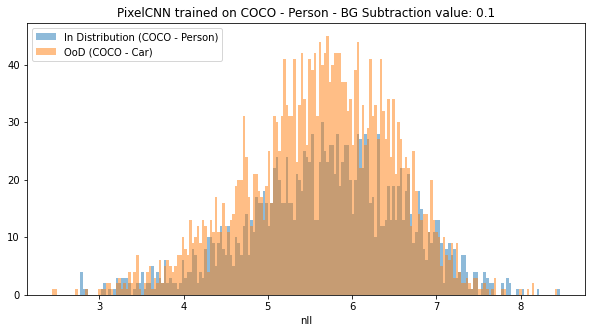

In [12]:
idd_losses = results[0:1750]
ood_losses = results[1751:4451]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Car)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - BG Subtraction value: 0.1')
plt.show()

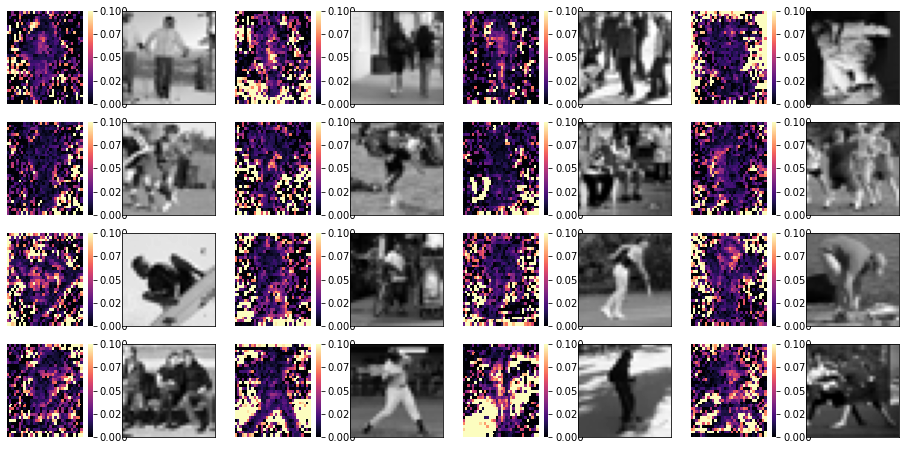

In [17]:
from src.utils.pixelcnn import draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img_bgSub, img_index=0, cmap='magma')

Training params: 
    - Batch size: 64
    - Image type: Full image
    - Background subtraction: True
    - Background subtraction value: 0.0
    - Image-size: 32 x 32
    - Optimizer: Adam
    - Initial LR: 0.001

In [5]:
experiment_name = 'PixelCNN_COCO_3_Full_Image_bs64_ks7_bgSub_0.0'

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.0000,
   patience=50,
   verbose=True,
)

logger = TensorBoardLogger(
            'lightning_logs', name=experiment_name)

trainer = Trainer(max_epochs=200, gpus=1,logger=logger,  
                  callbacks=[early_stop_callback], auto_lr_find=True, num_sanity_val_steps=0)

EarlyStopping mode set to min for monitoring val_loss.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


In [6]:
model = COCOPixelCNN(background_subtraction=True, background_subtraction_value=0.0, foreground_addition_value=0.0, 
                     kernel_size=7, padding=3)

trainer.fit(model, cocodata_person)

/nfs/students/winter-term-2020/project-4/yurtkulus/anaconda3/envs/ml-lab/lib/python3.8/site-packages/pytorch_lightning/utilities/distributed.py:45: RuntimeWarning: Found unsupported keys in the lr scheduler dict: ['name']
  warnings.warn(*args, **kwargs)
Set SLURM handle signals.

  | Name   | Type       | Params
--------------------------------------
0 | blocks | Sequential | 12 M  


1

In [6]:
from pathlib import Path

path = Path('models/' + experiment_name)
# path.mkdir(parents=True, exist_ok=True)


# trainer.save_checkpoint(str(path) + '/' + experiment_name + '.ckpt')

In [7]:
model_path = str(path) + '/' + experiment_name + '.ckpt'
eval_model_full_img_bgSub_0 = COCOPixelCNN().load_from_checkpoint(checkpoint_path=model_path, 
                                                                background_subtraction=True, 
                                                                background_subtraction_value=0.0, 
                                                                foreground_addition_value=0.0, 
                                                                kernel_size=7, padding=3).cuda()
eval_model_full_img_bgSub_0.eval()

COCOPixelCNN(
  (blocks): Sequential(
    (0): MaskedConv2d(1, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (10): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): MaskedConv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
    (13): Batc

In [8]:
targets, results = test_ood(trainer, eval_model_full_img_bgSub_0, cocodata_person, cocodata_car)

Set SLURM handle signals.


Set SLURM handle signals.


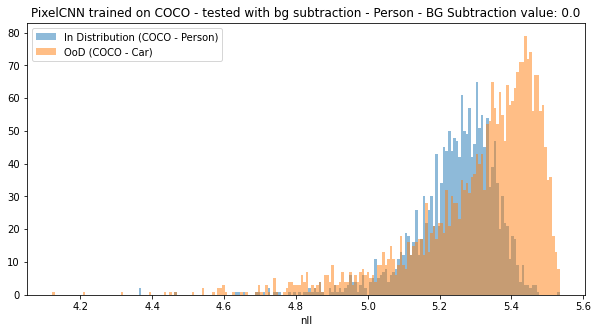

In [9]:
idd_losses = results[0:1750]
ood_losses = results[1751:4451]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Car)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - tested with bg subtraction - Person - BG Subtraction value: 0.0')
plt.show()

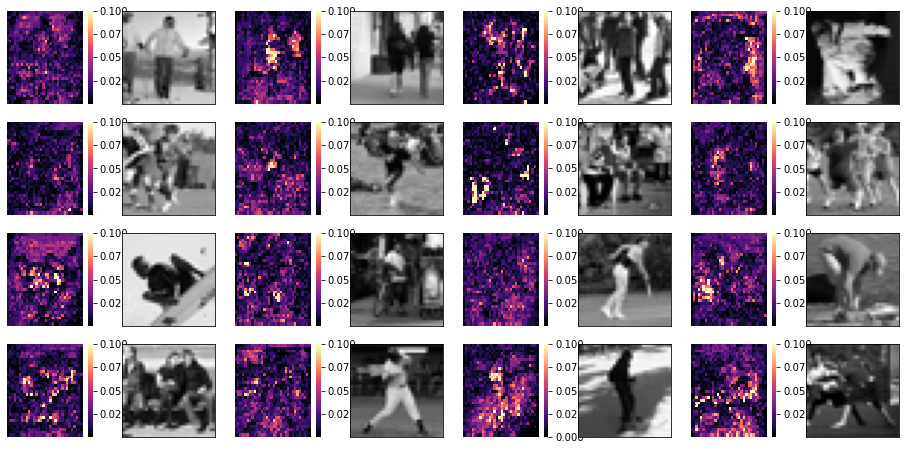

In [10]:
from src.utils.pixelcnn import draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img_bgSub_0, img_index=0, cmap='rocket')

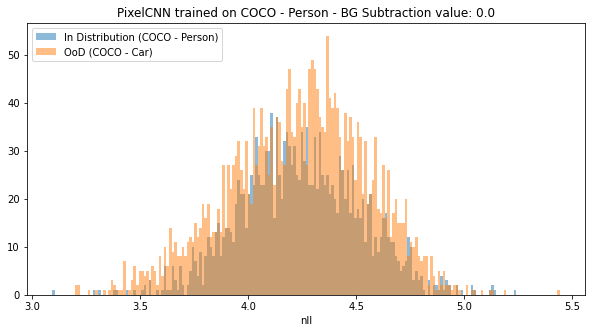

In [11]:
idd_losses = results[0:1750]
ood_losses = results[1751:4451]

plt.figure(figsize=(10,5))
bins = np.histogram(np.hstack((idd_losses,ood_losses)), bins=200)[1]
plt.hist(idd_losses, bins, alpha=0.5, label='In Distribution (COCO - Person)')
plt.hist(ood_losses, bins, alpha=0.5, label='OoD (COCO - Car)')
plt.legend(loc='upper left')
plt.xlabel('nll')
plt.title('PixelCNN trained on COCO - Person - BG Subtraction value: 0.0')
plt.show()

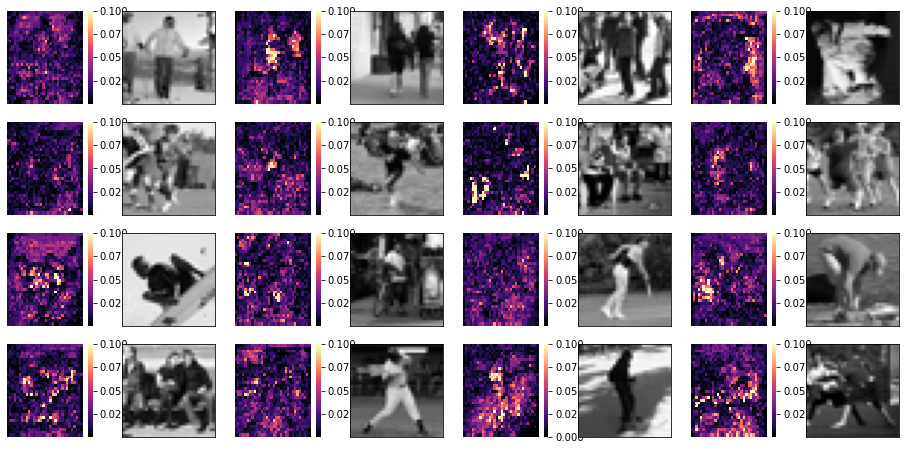

In [12]:
from src.utils.pixelcnn import draw_likelihood_plot
draw_likelihood_plot(cocodata_person.test_dataloader(), eval_model_full_img_bgSub_0, img_index=0, cmap='rocket')